In [62]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import func4behav as fb
from scipy.stats import lognorm, exponnorm, invgauss
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from pyddm import Model, Sample, Fittable, Fitted
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter, LossRobustLikelihood
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot

import imp
imp.reload(fb)

<module 'func4behav' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\behavior\\func4behav.py'>

In [63]:
case = 'exo'
behavior_compare, experiment = fb.create_allsubs_compare()
for subject_id in range (1,19):
    behavior_before, behavior_after = fb.load_behavior(subject_id)
    behavior_before, behavior_after = fb.filter_behav(case, behavior_before, behavior_after)
    behavior_compare = fb.allsubs_compare(subject_id, behavior_before, behavior_after, behavior_compare, experiment, verbose=False)
display(behavior_compare)

behavior_compare = behavior_compare.loc[(behavior_compare['response'] == 1) & (behavior_compare['reaction time'] > 0.05)]
rt_sham = behavior_compare.loc[behavior_compare['Real stimulation'] == 0]
rt_real = behavior_compare.loc[behavior_compare['Real stimulation'] == 1]
# rt_sham = fb.remove_outlier(rt_sham)
# rt_real = fb.remove_outlier(rt_real)
rt_sham_before = rt_sham.loc[rt_sham['session'] == 'before', 'reaction time'].values
rt_sham_after = rt_sham.loc[rt_sham['session'] == 'after', 'reaction time'].values
rt_real_before = rt_real.loc[rt_real['session'] == 'before', 'reaction time'].values
rt_real_after = rt_real.loc[rt_real['session'] == 'after', 'reaction time'].values

,subject id,trial,Real stimulation,session,type,cue,valid,ICS,stim,response,reaction time
0,1,1,1,before,2,1,1,0.5,1,1,0.27437
1,1,2,1,before,2,-1,1,1.0,-1,1,0.21226
2,1,7,1,before,2,-1,1,1.0,-1,1,0.17723
3,1,9,1,before,2,1,1,1.0,1,1,0.20720
4,1,10,1,before,2,1,-1,1.0,-1,1,0.24041
...,...,...,...,...,...,...,...,...,...,...,...
2155,18,109,1,after,2,-1,1,0.5,-1,1,0.38313
2156,18,114,1,after,2,-1,1,1.0,-1,1,0.30852
2157,18,118,1,after,2,1,-1,1.0,-1,1,0.32075
2158,18,119,1,after,2,-1,-1,0.5,1,1,0.46414


In [64]:
# Function to fit a shifted log-normal distribution
def compare_distributions(data, case):
    mse = np.ndarray([])
    log_L = np.ndarray([])

    bin_size = 30
    xmax = 1.5
    ymax = 80
    bin_edges = np.linspace(0, xmax, bin_size+1)

    # Plot the histogram of the data
    plt.hist(data, bins=bin_edges, density=True, alpha=0.6, color='blue', label='Reaction time histogram')

    methods = [fit_and_plot_shift_lognorm, fit_and_plot_exgaussian, fit_and_plot_ddm, fit_and_plot_shift_invgauss]
    for method in methods:
        mse_tmp, log_L_tmp = method(data, bin_edges)
        mse = np.append(mse, mse_tmp)
        log_L = np.append(log_L, log_L_tmp)
    
    plt.title('Distribution of reaction time: '+ case)
    plt.xlabel('Reaction Time (s)')
    plt.xlim(0, xmax)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

def log_likelihood(obs, pdf_values):
    epsilon = 1e-10  # Small constant to avoid taking log of zero
    return np.sum(np.log(pdf_values + epsilon))


def shifted_lognorm(x, s, scale, loc):
    return lognorm.pdf(x, s, loc=loc, scale=scale)

def fit_and_plot_shift_lognorm(data, bin_edges):

    # Estimate initial parameters
    shape, loc, scale = lognorm.fit(data, floc=0)
    params, _ = curve_fit(shifted_lognorm, np.sort(data), lognorm.pdf(np.sort(data), shape, loc=loc, scale=scale), p0=[shape, scale, loc])

    # Generate x values
    x = np.linspace(min(data), max(data), 1000)
    # Get the fitted distribution values
    fitted_values = shifted_lognorm(x, *params)
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)
    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    log_L = log_likelihood(hist, fitted_values_interpolated)
    # Plot the fitted shifted log-normal distribution
    plt.plot(x, fitted_values, 'y--', label=f"Shifted log-normal (MSE={mse:.3f}, L={log_L:.0f})")

    return mse, log_L


def fit_and_plot_exgaussian(data, bin_edges):
    # Fit Ex-Gaussian distribution
    K, loc, scale = exponnorm.fit(data)
    # Generate x values
    x = np.linspace(min(data), max(data), 1000)
    # Compute the Ex-Gaussian PDF
    fitted_values = exponnorm.pdf(x, K, loc, scale)
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)
    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    log_L = log_likelihood(hist, fitted_values_interpolated)
    # Plot the fitted Ex-Gaussian distribution
    plt.plot(x, fitted_values, 'g--', label=f"Ex-Gaussian (MSE={mse:.3f}, L={log_L:.0f})")

    return mse, log_L


def fit_and_plot_ddm(data, bin_edges):
    rt = data.copy()
    corr = np.ones(rt.shape[0])
    M = np.column_stack((rt, corr))

    ddm_data = Sample.from_numpy_array(M, [])

    model_fit = Model(name='My data (fitted)',
                    drift=DriftConstant(drift=Fittable(minval=6, maxval=7)),
                    noise=NoiseConstant(noise=Fittable(minval=1, maxval=2)),
                    bound=BoundConstant(B=Fittable(minval=1, maxval=2)),
                    overlay=OverlayNonDecision(nondectime=Fittable(minval=0.1, maxval=0.2)),
                    dx=.001, dt=.01, T_dur=2)
    fit_adjust_model(ddm_data, model_fit,
                    fitting_method="differential_evolution",
                    lossfunction=LossRobustLikelihood, verbose=False)
    # Get the fitted parameters
    params = model_fit.parameters()
    prediction = model_fit.solve()
    # histogram
    # Compute histogram
    hist, bin_edges = np.histogram(rt, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, prediction.t_domain, prediction.pdf("correct"))

    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    log_L = log_likelihood(hist, fitted_values_interpolated)
    plt.plot(prediction.t_domain, prediction.pdf("correct"), 'r--',label=f"DDM (MSE={mse:.3f}, L={log_L:.0f})")

    return mse, log_L


# Define the shifted inverse Gaussian distribution
def shifted_invgauss(x, mu, lamb, shift):
    return invgauss.pdf(x, mu=mu, loc=shift, scale=lamb)


def fit_and_plot_shift_invgauss(data, bin_edges):
    # Define initial parameters (you may need to change these depending on your data)
    mu_init = 1
    lamb_init = 1
    shift_init = 0

    # Fit the data to the shifted inverse Gaussian distribution
    params, _ = curve_fit(shifted_invgauss, np.sort(data), invgauss.pdf(np.sort(data), mu_init, scale=lamb_init), p0=[mu_init, lamb_init, shift_init])
    # Generate x values
    x = np.linspace(min(data), max(data), 1000)
    # Compute the fitted values
    fitted_values = shifted_invgauss(x, *params)
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)
    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    log_L = log_likelihood(hist, fitted_values_interpolated)
    # Plot the fitted shifted inverse Gaussian distribution
    plt.plot(x, fitted_values, 'c--', label=f"Shifted InvGauss (MSE={mse:.3f}, L={log_L:.0f})")

    return mse, log_L
    

Info: Params [6.15613727 1.19704966 1.23882611 0.12019823] gave -564.0365503381931


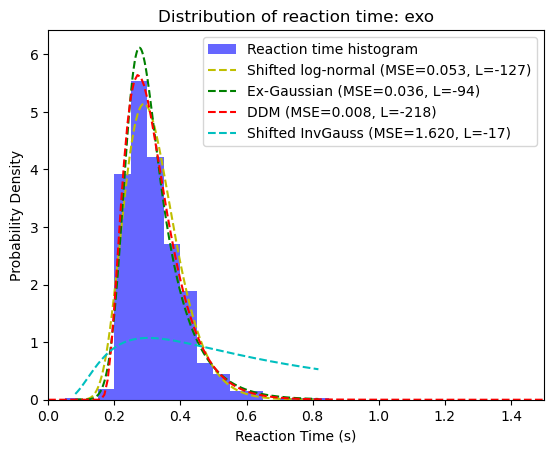

In [65]:
mse = compare_distributions(rt_sham_before, case)

In [66]:
# pyddm.plot.model_gui(model=model_fit, sample=data)